In [1]:
import pandas as pd
import re
import string
import numpy as np

In [21]:
df = pd.read_csv('anime_reviews.csv', index_col = 0)

## Cleaning Titles - For future use because the user who rates a show twice would need to be accounted for

In [3]:
def title_cleaner(text):
    text = re.sub(' \w*\d\w*', '', text)
    text = re.sub(' season', '', text)
    text = re.sub(' Season', '', text)
    text = re.sub(' Part', '', text)
    text = re.sub(' part', '', text)
    return text

cleaner_titles = lambda x: title_cleaner(x)

In [4]:
df.title = pd.DataFrame(df.title.apply(cleaner_titles))

## Seperating the nlp data and the ratings

In [5]:
df_scores = df[['user','title','user_score']]
df_reviews = df[['user','title','user_review']]
#anime_rating = df_scores.pivot_table(index='user', columns='title', values='user_score')


# Building a Model on Surprise

In [6]:
from surprise import SVD, KNNBasic, KNNBaseline, CoClustering, SVDpp, NMF, BaselineOnly, SlopeOne
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV

In [ ]:
# Use the famous SVD algorithm.
svd = SVD()
knn_basic = KNNBasic()
knn_baseline = KNNBaseline()
co_cluster = CoClustering()
svdpp = SVDpp()
nmf = NMF()
baseline = BaselineOnly()
slopeone = SlopeOne()


models = [svd, knn_basic, knn_baseline, co_cluster, 
          svdpp, nmf, baseline, slopeone]

# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(0, 10))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df_scores[['user', 'title', 'user_score']], reader)

# We can now use this dataset as we please, e.g. calling cross_validate

cross_validate(svd, data, cv=3)


In [ ]:
benchmark = []

for x in models:
    
    result = cross_validate(x, data, measures = ['RMSE'], cv=3, verbose = False)
    
    tmp = pd.DataFrame.from_dict(result).mean(axis=0)
    tmp = tmp.append(pd.Series([str(x).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    

In [ ]:
pd.DataFrame(benchmark).set_index('Algorithm')

In [ ]:
param_grid = {'n_factors': [50, 100, 150, 200, 250, 300], 
              'n_epochs': [5, 10, 15, 20, 25, 30],
              'lr_all': [.0025, .005, .01, .025, .05],
              'reg_all': [.005, .01, .02, .05, .1]}

In [ ]:
svd_gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=-1)
svd_gs.fit(data)

In [ ]:
print('RMSE:', round(svd_gs.best_score['rmse'], 4), 
      '; MAE:', round(svd_gs.best_score['mae'], 4))

In [ ]:
print('RMSE =', svd_gs.best_params['rmse'])

## Attempting Train Test Splitb

In [ ]:
trainset, testset = train_test_split(data, test_size=.25)

svd_best = SVD(n_factors = 200, n_epochs = 15, lr_all = .05, reg_all = .1)
# Train the algorithm on the trainset, and predict ratings for the testset
svd_best.fit(trainset)
predictions = svd_best.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

# Working with the NLP Data

## Cleaning the NLP data

In [7]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [8]:
stopwords_list = stopwords.words('english')
# # lemmatizer = WordNetLemmatizer()

In [9]:
def review_cleaner(text):
    text = re.sub(r'.*Overall.*Enjoyment...', '', text, flags=re.DOTALL )
    text = re.sub(r'Helpful...read more.$', '', text, flags=re.DOTALL )
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', ' ', text)
    text = re.sub('\n', ' ', text)
    text = re.sub("\s+"," ", text)
    text = text.lower()
    return text

cleaner = lambda x: review_cleaner(x)

In [10]:
df_reviews.user_review = pd.DataFrame(df_reviews.user_review.apply(cleaner))

/Users/antoniohila/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


## Lemmatizing/Tokenizing Words

In [ ]:
# lemmatized_words = [lemmatizer.lemmatize(word) for words in tokenized_list for word in words]

In [11]:
tokenized_list = [word_tokenize(x) for x in df_reviews.user_review
                  if x not in stopwords_list]

In [12]:
df_reviews.user_review = [' '.join(x) for x in tokenized_list]

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(preprocessor = cleaner, ngram_range=(1, 1), min_df=0.0001, stop_words='english')
tfidf_matrix = tfidf.fit_transform(df_reviews['user_review'])


In [ ]:
pd.DataFrame(tfidf_matrix.toarray(), columns = tfidf.get_feature_names(), index = df_reviews['user'])


In [ ]:
# pairwise_similarity = tfidf_matrix * tfidf_matrix.T 

## Textblob

In [13]:
from textblob import TextBlob

In [14]:
sentiment_score = []

In [15]:
for x in df_reviews.user_review:
    text = x
    blob = TextBlob(text)
    if len(x) <= 5:
        sentiment_score.append(0)
    else:
        for sentence in blob.sentences:
            sentiment_score.append(sentence.sentiment.polarity)

In [16]:
sentiment_df = pd.DataFrame(sentiment_score, columns = ['Sentiment_score'])

## SpaCy

In [17]:
import spacy
from tqdm import tqdm

In [18]:
tqdm.pandas()

/Users/antoniohila/opt/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [19]:
nlp = spacy.load('en_core_web_md')

In [20]:
df_reviews['spacy_score'] = df_reviews.user_review.progress_apply(lambda x: nlp(x))

100%|██████████| 72056/72056 [55:51<00:00, 21.50it/s]   


In [24]:
df_reviews['spacy'] = [x.vector_norm for x in df_reviews['spacy_score']] 

In [25]:
spacy_df = pd.DataFrame(df_reviews.spacy)

In [ ]:
# # Use the famous SVD algorithm.
# svd = SVD(n_factors= 200, n_epochs= 15, lr_all= 0.05, reg_all= 0.1)

# # A reader is still needed but only the rating_scale param is requiered.
# reader = Reader(rating_scale=(0, 8))

# # The columns must correspond to user id, item id and ratings (in that order).
# data = Dataset.load_from_df(df_reviews[['user', 'title', 'spacy']], reader)

# # We can now use this dataset as we please, e.g. calling cross_validate

# cross_validate(svd, data, cv=3)


## Creating a recommendation system using sentiment score

In [26]:
df_all_scores = pd.concat([df_scores, sentiment_df, spacy_df], axis = 1)

In [27]:
df_all_scores['sentiment_x_rating'] = [df_all_scores.user_score[i] * df_all_scores.Sentiment_score[i] 
                                   for i in range(len(df_all_scores.user_score))]


In [29]:
df_all_scores['abs_score'] = np.abs(df_all_scores['sentiment_x_rating'])

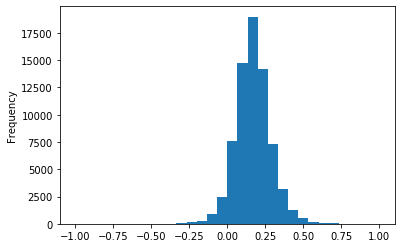

In [43]:
df_all_scores['Sentiment_score'].plot.hist(bins = 30)

In [76]:
df_all_scores.to_csv('all_ratings.csv')

In [32]:
svd = SVD(n_factors= 200, n_epochs= 15, lr_all= 0.05, reg_all= 0.1)


reader = Reader(rating_scale=(1,10))


# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df_all_scores[['user', 'title', 'user_score']], reader)

# We can now use this dataset as we please, e.g. calling cross_validate

cross_validate(svd, data, cv=3)

{'test_rmse': array([1.84421824, 1.83939289, 1.8681244 ]),
 'test_mae': array([1.40322514, 1.40177295, 1.41623484]),
 'fit_time': (3.225882053375244, 3.295788049697876, 3.255263090133667),
 'test_time': (0.15830278396606445, 11.781933784484863, 0.1378161907196045)}

In [44]:
svd = SVD(n_factors= 200, n_epochs= 15, lr_all= 0.05, reg_all= 0.1)


reader = Reader(rating_scale=(0, 10))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df_all_scores[['user', 'title', 'abs_score']], reader)

# We can now use this dataset as we please, e.g. calling cross_validate

cross_validate(svd, data, cv=3)

{'test_rmse': array([0.95225882, 0.96126738, 0.96254131]),
 'test_mae': array([0.7326995 , 0.73601855, 0.740965  ]),
 'fit_time': (3.260472059249878, 3.430147171020508, 3.436102867126465),
 'test_time': (0.16557598114013672, 0.14572596549987793, 0.1503889560699463)}

In [45]:
##### svd = SVD(n_factors= 200, n_epochs= 15, lr_all= 0.05, reg_all= 0.1)


reader = Reader(rating_scale=(-1, 1))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df_all_scores[['user', 'title', 'Sentiment_score']], reader)

# We can now use this dataset as we please, e.g. calling cross_validate

cross_validate(svd, data, cv=3)

{'test_rmse': array([0.11416956, 0.11476375, 0.11382097]),
 'test_mae': array([0.08483617, 0.08500448, 0.08420482]),
 'fit_time': (3.4176549911499023, 3.3941709995269775, 3.448697805404663),
 'test_time': (0.1620030403137207, 0.14563989639282227, 0.7509009838104248)}

In [46]:
svd = SVD(n_factors= 200, n_epochs= 15, lr_all= 0.05, reg_all= 0.1)


reader = Reader(rating_scale=(0, 10))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df_all_scores[['user', 'title', 'spacy']], reader)

# We can now use this dataset as we please, e.g. calling cross_validate

cross_validate(svd, data, cv=3)

{'test_rmse': array([0.27643067, 0.28581231, 0.27441909]),
 'test_mae': array([0.12303776, 0.1242959 , 0.12213   ]),
 'fit_time': (3.292006731033325, 3.3401339054107666, 3.3667449951171875),
 'test_time': (0.14704418182373047, 0.1527550220489502, 0.7364861965179443)}

In [36]:
print('User Score normalized variance: ' + str(1.83627519/9))
print('Abs of sentiment and user score normalized variance: ' + str(0.95093312/5))
print('Sentiment Score normalized variance: ' + str(0.11383248/1.25))
print('Spacy Score normalized variance: ' + str(0.27252617/3))

User Score normalized variance: 0.20403057666666669
Abs of sentiment and user score normalized variance: 0.190186624
Sentiment Score normalized variance: 0.091065984
Spacy Score normalized variance: 0.09084205666666667


# Zawar Code

In [53]:
from collections import defaultdict
from surprise import Dataset
from surprise import SVD

In [ ]:
def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.
    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.
    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''
    # First map the predictions to each user.
    top_n = defaultdict(list)
    
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    # Then sort the predictions for each user and retrieve the k highest ones.
    
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
        
    return top_n

# First train an SVD algorithm on the movielens dataset.
reader = Reader(rating_scale=(0, 10))

data = Dataset.load_from_df(df_scores[['user', 'title', 'user_score']], reader)
trainset = data.build_full_trainset()

svd = SVD(n_factors= 200, n_epochs= 15, lr_all= 0.05, reg_all= 0.1)

svd.fit(trainset)
# Than predict ratings for all pairs (u, i) that are NOT in the training set.


testset = trainset.build_anti_testset()

predictions = svd.test(testset)

top_n_baseline = get_top_n(predictions, n=3)


# Print the recommended items for each user
for uid, user_ratings in top_n_baseline.items():
    print(uid, [iid for (iid, _) in user_ratings])

In [ ]:
def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.
    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.
    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''
    # First map the predictions to each user.
    top_n = defaultdict(list)
    
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    # Then sort the predictions for each user and retrieve the k highest ones.
    
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
        
    return top_n

# First train an SVD algorithm on the movielens dataset.
reader = Reader(rating_scale=(-5, 5))

data = Dataset.load_from_df(df_all_scores[['user', 'title', 'final_score']], reader)
trainset = data.build_full_trainset()

svd = SVD(n_factors= 200, n_epochs= 15, lr_all= 0.05, reg_all= 0.1)

svd.fit(trainset)
# Than predict ratings for all pairs (u, i) that are NOT in the training set.


testset = trainset.build_anti_testset()

predictions = svd.test(testset)

top_n_baseline = get_top_n(predictions, n=3)


# Print the recommended items for each user
for uid, user_ratings in top_n_baseline.items():
    print(uid, [iid for (iid, _) in user_ratings])

In [ ]:
def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.
    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.
    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''
    # First map the predictions to each user.
    top_n = defaultdict(list)
    
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    # Then sort the predictions for each user and retrieve the k highest ones.
    
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
        
    return top_n

# First train an SVD algorithm on the movielens dataset.
reader = Reader(rating_scale=(-.5, .75))

data = Dataset.load_from_df(df_all_scores[['user', 'title', 'Sentiment_score']], reader)
trainset = data.build_full_trainset()

svd = SVD(n_factors= 200, n_epochs= 15, lr_all= 0.05, reg_all= 0.1)

svd.fit(trainset)
# Than predict ratings for all pairs (u, i) that are NOT in the training set.


testset = trainset.build_anti_testset()

predictions = svd.test(testset)

top_n_baseline = get_top_n(predictions, n=3)


# Print the recommended items for each user
for uid, user_ratings in top_n_baseline.items():
    print(uid, [iid for (iid, _) in user_ratings])

## Our reviews

In [47]:
antonio = [{'user': 'antonio_hila', 'title': 'Sword Art Online', 'user_score': 7},
           {'user': 'antonio_hila', 'title': 'Steins;Gate', 'user_score': 9},
           {'user': 'antonio_hila', 'title': 'Your Lie in April', 'user_score': 9},
           {'user': 'antonio_hila', 'title': 'Cowboy Bebop', 'user_score': 10},
           {'user': 'antonio_hila', 'title': 'Naruto', 'user_score': 5},
           {'user': 'antonio_hila', 'title': 'Death Parade', 'user_score': 8},
           {'user': 'antonio_hila', 'title': 'Death Note', 'user_score': 7},
           {'user': 'antonio_hila', 'title': 'No Game, No Life', 'user_score': 8},
           {'user': 'antonio_hila', 'title': 'Noragami: Stray God', 'user_score': 7}
           ]

zawar = [{'user': 'zawar_ahmed', 'title': 'Fullmetal Alchemist: Brotherhood', 'user_score': 8},
         {'user': 'zawar_ahmed', 'title': 'Hunter x Hunter', 'user_score': 10},
         {'user': 'zawar_ahmed', 'title': 'Demon Slayer: Kimetsu no Yaiba', 'user_score': 9},
         {'user': 'zawar_ahmed', 'title': 'Fairy Tail', 'user_score': 4},
         {'user': 'zawar_ahmed', 'title': "JoJo's Bizarre Adventure", 'user_score': 9},
        ]

omar = [{'user': 'omar_hussain', 'title': 'One Piece', 'user_score': 9}, 
        {'user': 'omar_hussain', 'title': 'My Hero Academia', 'user_score': 8}, 
        {'user': 'omar_hussain', 'title': 'Attack on Titan', 'user_score': 7}, 
        {'user': 'omar_hussain', 'title': 'Dr. Stone', 'user_score': 8}, 
        {'user': 'omar_hussain', 'title': 'Black Clover', 'user_score': 8}, 
        {'user': 'omar_hussain', 'title': 'Castlevania', 'user_score': 9}, 
        {'user': 'omar_hussain', 'title': 'Naruto: Shippuden', 'user_score': 7}, 
        {'user': 'omar_hussain', 'title': 'Naruto', 'user_score': 5}, 
        {'user': 'omar_hussain', 'title': 'Fairy Tail', 'user_score': 6}, 
        {'user': 'omar_hussain', 'title': 'Assassination Classroom', 'user_score': 7},
        {'user': 'omar_hussain', 'title': 'Mob Psycho', 'user_score': 8},
        {'user': 'omar_hussain', 'title': 'Kabaneri of the Iron Fortress', 'user_score': 6}
       ]

squid = [{'user': 'erando_hila', 'title': 'Angel Beats!', 'user_score': 6},
         {'user': 'erando_hila', 'title': 'Code Geass: Lelouch of the Rebellion', 'user_score': 10},
         {'user': 'erando_hila', 'title': 'Bakemonogatari', 'user_score': 8},
         {'user': 'erando_hila', 'title': 'Cowboy Bebop', 'user_score': 8},
         {'user': 'erando_hila', 'title': 'Death Note', 'user_score': 8},
         {'user': 'erando_hila', 'title': 'Fullmetal Alchemist', 'user_score': 7},
         {'user': 'erando_hila', 'title': 'Fullmetal Alchemist: Brotherhood', 'user_score': 10},
         {'user': 'erando_hila', 'title': 'The Devil is a Part-Timer!', 'user_score': 4},
         {'user': 'erando_hila', 'title': 'When They Cry', 'user_score': 9},
         {'user': 'erando_hila', 'title': "Kuroko's Basketball", 'user_score': 8},
         {'user': 'erando_hila', 'title': 'The Future Diary', 'user_score': 6},
         {'user': 'erando_hila', 'title': 'Black Butler', 'user_score': 5},
         {'user': 'erando_hila', 'title': 'Attack on Titan', 'user_score': 7},
         {'user': 'erando_hila', 'title': 'Steins;Gate', 'user_score': 10}
        ]

In [48]:
df_score = pd.concat([df_scores, pd.DataFrame(antonio), pd.DataFrame(zawar), 
                     pd.DataFrame(omar), pd.DataFrame(squid)], axis = 0)

In [49]:
df_score.reset_index(inplace = True)

In [50]:
df_score.drop(columns = ['index'], inplace = True)

In [51]:
# First train an SVD algorithm on the movielens dataset.
reader = Reader(rating_scale=(1, 10))

data = Dataset.load_from_df(df_score[['user', 'title', 'user_score']], reader)

trainset = data.build_full_trainset()

svd = SVD(n_factors= 200, n_epochs= 15, lr_all= 0.05, reg_all= 0.1)


svd.fit(trainset)

# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()

predictions = svd.test(testset)

In [73]:
predictions[-3792:]

[Prediction(uid='antonio_hila', iid='Fullmetal Alchemist: Brotherhood', r_ui=7.91059143364403, est=8.757703435771012, details={'was_impossible': False}),
 Prediction(uid='antonio_hila', iid='Gintama', r_ui=7.91059143364403, est=8.756635026504005, details={'was_impossible': False}),
 Prediction(uid='antonio_hila', iid='Hunter x Hunter', r_ui=7.91059143364403, est=8.485145514539097, details={'was_impossible': False}),
 Prediction(uid='antonio_hila', iid='Attack on Titan', r_ui=7.91059143364403, est=7.392987927179053, details={'was_impossible': False}),
 Prediction(uid='antonio_hila', iid='Gintama: Enchousen', r_ui=7.91059143364403, est=8.32927626575957, details={'was_impossible': False}),
 Prediction(uid='antonio_hila', iid='March Comes In Like A Lion', r_ui=7.91059143364403, est=8.666595710580836, details={'was_impossible': False}),
 Prediction(uid='antonio_hila', iid='Clannad ~After Story~', r_ui=7.91059143364403, est=8.540065261764182, details={'was_impossible': False}),
 Prediction(u

In [75]:
def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.
    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.
    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''
    # First map the predictions to each user.
    top_n = defaultdict(list)
    
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    # Then sort the predictions for each user and retrieve the k highest ones.
    
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
        
    return top_n

top_n_baseline = get_top_n(predictions[-3792:], n=10)

# Print the recommended items for each user
for uid, user_ratings in top_n_baseline.items():
    print(uid, [iid for (iid, _) in user_ratings])
    print()

antonio_hila ['Descending Stories: Showa Genroku Rakugo Shinju', 'Mob Psycho II', 'Fighting Spirit', 'Mononoke', 'Showa Genroku Rakugo Shinju', 'Owarimonogatari Second', 'Great Teacher Onizuka', 'Mushi-Shi', 'Haikyu!!', 'Fullmetal Alchemist: Brotherhood']

zawar_ahmed ['Owarimonogatari Second', 'Showa Genroku Rakugo Shinju', 'Princess Tutu', 'Gurren Lagann', 'Hyouge Mono', 'Major', 'Tanoshii Muumin Ikka', 'Gintama', 'Great Teacher Onizuka', 'Interspecies Reviewers']

omar_hussain ['Cowboy Bebop', 'Gintama', 'Monster', 'Descending Stories: Showa Genroku Rakugo Shinju', 'Owarimonogatari Second', 'Showa Genroku Rakugo Shinju', 'Mob Psycho II', "Kino's Journey", 'Mononoke', 'Fighting Spirit']

erando_hila ['March Comes In Like A Lion', 'Descending Stories: Showa Genroku Rakugo Shinju', 'Owarimonogatari Second', 'Monster', 'Run with the Wind', 'Aria the Origination', 'Mob Psycho II', 'Mononoke', 'Showa Genroku Rakugo Shinju', 'Made in Abyss']

